In [68]:

import os
import inspect
import sys
sys.path.insert(0, "../")


from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt



import pandas as pd
import numpy as np
import logging
import pprint
import re
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 1
# mpl.rcParams['legend.fontsize'] = 13

# mpl.rcParams['axes.titlesize'] = 15
# mpl.rcParams['axes.labelsize'] = 13
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# Define the potting



In [70]:
import numpy as np

In [71]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
# with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
with DatabaseHandler(logger,"../experiments/experiments.db") as dbHandler:

    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            # replace null in the column string by 0
            column = column.replace("null","0")
            # replace Infinity in the column string by np.inf
            column = column.replace("Infinity","np.inf")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        if len(exploded[column].tolist()) > 0:
            exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)
        else:
            exploded[new_column] = np.nan
            # set attack_epsilon
            exploded["attack_epsilon"] = np.nan

    exploded = exploded.drop(columns=columns)
    return exploded


def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss","boundary_loss_test"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","first_term_fair_errors","second_term_fair_errors","third_term_fair_errors","test_losses","data_model_adversarial_generalization_errors","gamma_robustness_es","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","first_term_fair_error","second_term_fair_error","third_term_fair_error","test_loss","data_model_adversarial_generalization_error","gamma_robustness","boundary_loss_test"] #
    # columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","second_term_fair_errors","test_losses","data_model_adversarial_generalization_errors"]
    # new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","second_term_fair_error","test_loss","data_model_adversarial_generalization_error"] #
    return explode_measures(df, new_columns, columns)
    

df_erm = explode_erm_measures(df_erm)

df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  103


In [72]:
def extract_first_eigenvalue(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(array[0])])
def extract_second_eigenvalue(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(array[-1])])
def extract_trace(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(sum(array))])

df2 = df_state_evolution.reset_index()


df2["sigmax_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "sigmax_eigenvalues"), axis=1)
df2["sigmax_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "sigmax_eigenvalues"), axis=1)
df2["sigmax_trace"] = df2.apply(lambda row: extract_trace(row, "sigmax_eigenvalues"), axis=1)

df2["sigmatheta_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "sigmatheta_eigenvalues"), axis=1)
df2["sigmatheta_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "sigmatheta_eigenvalues"), axis=1)
df2["sigmatheta_trace"] = df2.apply(lambda row: extract_trace(row, "sigmatheta_eigenvalues"), axis=1)

df2["xtheta_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "xtheta_eigenvalues"), axis=1)
df2["xtheta_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "xtheta_eigenvalues"), axis=1)
df2["xtheta_trace"] = df2.apply(lambda row: extract_trace(row, "xtheta_eigenvalues"), axis=1)

# columns = ["sigmax_first_ev","sigmax_second_ev","sigmax_trace","sigmatheta_first_ev","sigmatheta_second_ev","sigmatheta_trace","xtheta_first_ev","xtheta_second_ev","xtheta_trace"]

# for column in columns:
#     # apply mean and std to the new column
#     df_result = df2[column].apply(lambda x: pd.Series({"mean":x, "std":0}))
#     multiindex = pd.MultiIndex.from_product([[column], ['mean', 'std']], names=['', ''])
#     df_result.columns = multiindex
#     # Concatenate the original DataFrame with the computed values DataFrame
#     df2 = pd.concat([df2, df_result], axis=1)

# drop the original eigenvalues columns
df2 = df2.drop(columns=["sigmax_eigenvalues","sigmatheta_eigenvalues","xtheta_eigenvalues"])

df_state_evolution = df2


In [73]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
version_choice = "100"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(5)

,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,...,taus,ps,dp,d,experiment_type,completed,data_model_types,data_model_names,data_model_descriptions,gamma_fair_error
80,06469b8a-0beb-43c6-807b-19912e5ae7f1,Defence Sweep,10.029958,"[""Logistic""]",100,2024-02-01 22:00:57,1,0,"[0.1585, 0.3244, 0.6641, 1.3594, 2.7826, 5.695...","[0.0, 0.2, 0.4]",...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingIdentit...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
79,e18d3754-1275-43f9-8238-b6961ac1600e,FeatureComparisonsTest,22.733641,"[""Logistic""]",100,2024-01-31 22:15:19,1,0,"[10.0, 35.9381, 129.155, 464.1589, 1668.1005, ...","[0.0, 1, 10, 100]",...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
78,a6fb5c19-4cc1-4b7a-91f0-01308f234edf,FeatureComparisonsTest,32.775683,"[""Logistic""]",100,2024-01-31 22:04:35,1,0,"[10.0, 35.9381, 129.155, 464.1589, 1668.1005, ...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
77,ad9f90d4-214e-4b1e-90e0-3e897b8863a9,FeatureComparisonsTest,133.059219,"[""Logistic""]",100,2024-01-31 20:14:08,1,0,[1000],"[0.001, 0.0022, 0.0046, 0.01, 0.0215, 0.0464, ...",...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
76,8012f49d-53ad-4e46-aace-f21882edf499,FeatureComparisonsTest,12.244287,"[""Logistic""]",100,2024-01-31 18:12:02,1,0,[50],"[0.001, 0.0022, 0.0046, 0.01, 0.0215, 0.0464, ...",...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001


In [74]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [75]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

06469b8a-0beb-43c6-807b-19912e5ae7f1
Sweep
KFeaturesModel
KFeaturesModel
KFeaturesModel
['KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_1_SU_1_1___Defence Sweep', 'KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_2_1_SU_1_1___Defence Sweep', 'KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_2_SU_1_1___Defence Sweep']
["2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity", "2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta First Protectes", "2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Second Protected"]
Defence Sweep
['Logistic']


In [76]:
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[10  1]"] = "Strong Weak 10:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[ 1 10]"] = "Strong Weak 10:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1"] = "Robust Non-Useful"

data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[2 2]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[4 4]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[0.5 0.5]_SD_1_1_SU_1_1"] = "Robust Non-Useful"


data_model_name_dict['KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[2 2]_SD_1_1_SU_1_1'] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[8 8]_SD_1_1_SU_1_1"] = "Non-Robust Useful"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2.  0.5]_[1 1]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[1 1]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"


data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_1_SU_1_1"] = "Invariant Defence"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_2_1_SU_1_1"] = "Protecting Robust"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_2_SU_1_1"] = "Protecting Non-Robust"

# 'KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_1_SU_1_1___Defence Sweep', 'KFeaturesModel_TwoFeatures_ProtectingFirstStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_2_1_SU_1_1___Defence Sweep', 'KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5.  0.2]_[0.2 5. ]_SD_1_2_SU_1_1___Defence Sweep'

In [77]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50763/3541688095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50763/3541688095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))


In [78]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [79]:
# def compute_mu_usefulness(row):
#     rho = row["rho"]
#     tau = row["tau"]

#     rho = float(rho)
#     tau = float(tau)

#     return np.sqrt(2 / np.pi) * rho / np.sqrt( rho + tau**2 )

# def compute_gamma_robustness(row):
#     rho = row["rho"]
#     tau = row["tau"]


#     rho = float(rho)
#     tau = float(tau)

#     return np.sqrt(2 / np.pi) * tau / np.sqrt( rho + tau**2 )

# def compute_mu_usefulness_ratio(row):

In [80]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [81]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [82]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [83]:
def noiseless_angle_to_generalisation(angle):
    return np.arccos(angle) / np.pi

state_evolution["noiseless_angle_to_generalisation"] = state_evolution.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)
gd["noiseless_angle_to_generalisation"] = gd.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)

In [84]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [85]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)

In [86]:
# strip the data_model_name if there is a sequence ___text at the end
def strip_data_model_name(data_model_name):
    return re.sub(r"___.*","",data_model_name)
state_evolution["data_model_name"] = state_evolution["data_model_name"].apply(strip_data_model_name)
gd["data_model_name"] = gd["data_model_name"].apply(strip_data_model_name)

In [87]:
def extract_theta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-1].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()
    

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_second # / theta_first  


state_evolution["theta_ratio"] = state_evolution["data_model_name"].apply(extract_theta_ratio)
gd["theta_ratio"] = gd["data_model_name"].apply(extract_theta_ratio)

In [88]:
def extract_sigmax_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-2].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_first # / theta_second


state_evolution["sigmax_ratio"] = state_evolution["data_model_name"].apply(extract_sigmax_ratio)
gd["sigmax_ratio"] = gd["data_model_name"].apply(extract_sigmax_ratio)

In [89]:
def extract_sigmadelta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_second  #/ theta_first

def extract_sigmadelta_scale(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_first


state_evolution["sigmadelta_ratio"] = state_evolution["data_model_name"].apply(extract_sigmadelta_ratio)
gd["sigmadelta_ratio"] = gd["data_model_name"].apply(extract_sigmadelta_ratio)

state_evolution["sigmadelta_scale"] = state_evolution["data_model_name"].apply(extract_sigmadelta_scale)
gd["sigmadelta_scale"] = gd["data_model_name"].apply(extract_sigmadelta_scale)

In [90]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6,7,8,9]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6,7,8,9]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

index_state_evolution  \
                                                                                                                                                                      mean   
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                                            
0.1585   0.0     0.05 0.001 Logistic     0.2            5.0          1.0              5.0         KFeaturesModel_TwoFeatures_ProtectingFirstStron...                5773.0   
                                                                                                  KFeaturesModel_TwoFeatures_ProtectingIdentity_A...                5774.0   
                                                                     2.0              5.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5815.0   
         0.2     0.05 0.001 Logistic     0.2            5.0          1.0              5.0         KFeaturesModel_TwoFeatures_ProtectingFirstStron...                5781.0   
                                                                                                  KFeaturesModel_TwoFeatures_ProtectingIdentity_A...                5778.0   
...                                                                                                                                                                    ...   
100.0000 0.2     0.05 0.001 Logistic     0.2            5.0          1.0              5.0         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...                5802.0   
                                                                     2.0              5.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5849.0   
         0.4     0.05 0.001 Logistic     0.2            5.0          1.0              5.0         KFeaturesModel_TwoFeatures_ProtectingFirstStron...                5823.0   
                                                                                                  KFeaturesModel_TwoFeatures_ProtectingIdentity_A...                5786.0   
                                                                     2.0              5.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5850.0   

                                                                                                                                                          \
                                                                                                                                                     std   
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                          
0.1585   0.0     0.05 0.001 Logistic     0.2            5.0          1.0              5.0         KFeaturesModel_TwoFeatures_ProtectingFirstStron... NaN   
                                                                                                  KFeaturesModel_TwoFeatures_ProtectingIdentity_A... NaN   
                                                                     2.0              5.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.2     0.05 0.001 Logistic     0.2            5.0          1.0              5.0         KFeaturesModel_TwoFeatures_ProtectingFirstStron... NaN   
                                                                                                  KFeaturesModel_TwoFeatures_ProtectingIdentity_A... NaN   
...                                                                                                                                                   ..   
100.0000 0.2     0.05 0.001 Logistic     0.2            5.0          1.0              5.0         KFeaturesModel_TwoFeatures_ProtectingIdentity_A... NaN   
                                                                     2.0              5.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN

In [91]:
def extract_rho_norm_usefulness(row):
    # extract sigmax_ratio from the index
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)

    norm = (sigmax_ratio + sigmatheta_ratio**2) * 0.5

    subspace_rho_1 = sigmax_ratio / (2 * norm)

    usefulness = subspace_rho_1 / ( 1 - subspace_rho_1 )

    subspace_rho_2 = sigmatheta_ratio**2 / (2*norm)

    assert subspace_rho_1 + subspace_rho_2 - 1 < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_rho_1, subspace_rho_2)


    return usefulness

def extract_trace_norm_usefulness(row):
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]
    rho = row["rho_state_evolution"]["mean"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)
    rho = float(rho)

    norm = (1/4) * (1 + sigmax_ratio) * ( 1 + sigmatheta_ratio**2)

    subspace_1 = 0.5 * sigmax_ratio / norm
    subspace_2 = 0.5 * sigmatheta_ratio**2 / norm

    # assert subspace_1 + subspace_2 - rho < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_1, subspace_2)

    usefulness = subspace_1 / ( rho - subspace_1 )

    return usefulness

def extract_relative_usefulness(row):
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)

    return sigmax_ratio / sigmatheta_ratio**2

def extract_usefulness(row):
    rho = row["rho_state_evolution"]["mean"]
    rho = float(rho)
    return rho


df2 = df.reset_index()


df2["total_usefulness"] = df2.apply(extract_usefulness, axis=1)

# # apply mean and std to the new column
# df_result = df2["total_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['total_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


df2["rho_usefulness"] = df2.apply(extract_rho_norm_usefulness, axis=1)


# apply mean and std to the new column
df_result = df2["rho_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['rho_usefulness'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

df2["trace_usefulness"] = df2.apply(extract_trace_norm_usefulness, axis=1)

# apply mean and std to the new column
df_result = df2["trace_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['trace_usefulness'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

df2["relative_usefulness"] = df2.apply(extract_relative_usefulness, axis=1)

# apply mean and std to the new column
# df_result = df2["relative_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['relative_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

# # apply mean and std to the column "theta_ratio"
# df_result = df2["theta_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['theta_ratio'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df_result = df2["sigmax_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['sigmax_ratio'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


# set all quantities from the df index in df2 as index
# df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","relative_usefulness","data_model_name"]) #,"p_calibration"
# df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) 
df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","theta_ratio","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) #,"p_calibration"


# sort index
df.sort_index()



/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50763/1728979210.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmax_ratio = float(sigmax_ratio)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50763/1728979210.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmatheta_ratio = float(sigmatheta_ratio)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50763/1728979210.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmax_ratio = float(sigmax_ratio)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50763/1728979210.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(

index_state_evolution  \
                                                                                                                                                                                       mean   
alpha    epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio sigmadelta_ratio total_usefulness data_model_name                                                            
0.1585   0.0     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingFirstStron...                5773.0   
                                                                                                                   KFeaturesModel_TwoFeatures_ProtectingIdentity_A...                5774.0   
                                                                                 2.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5815.0   
         0.2     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingFirstStron...                5781.0   
                                                                                                                   KFeaturesModel_TwoFeatures_ProtectingIdentity_A...                5778.0   
...                                                                                                                                                                                     ...   
100.0000 0.2     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingIdentity_A...                5802.0   
                                                                                 2.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5849.0   
         0.4     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingFirstStron...                5823.0   
                                                                                                                   KFeaturesModel_TwoFeatures_ProtectingIdentity_A...                5786.0   
                                                                                 2.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5850.0   

                                                                                                                                                                           \
                                                                                                                                                                      std   
alpha    epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio sigmadelta_ratio total_usefulness data_model_name                                          
0.1585   0.0     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingFirstStron... NaN   
                                                                                                                   KFeaturesModel_TwoFeatures_ProtectingIdentity_A... NaN   
                                                                                 2.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.2     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingFirstStron... NaN   
                                                                                                                   KFeaturesModel_TwoFeatures_ProtectingIdentity_A... NaN   
...                                                                                                        

In [92]:
# try replacing data_model_name in df with data_model_name_dict
df = df.reset_index()
df["data_model_name"] = df["data_model_name"].apply(lambda x: data_model_name_dict[x])
df = df.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","theta_ratio","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) #,"p_calibration"
df.sort_index()

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50763/2753849964.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50763/2753849964.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = df.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","theta_ratio","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) #,"p_calibration"


index_state_evolution  \
                                                                                                                                                          mean   
alpha    epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio sigmadelta_ratio total_usefulness data_model_name                               
0.1585   0.0     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              Invariant Defence                    5774.0   
                                                                                                                   Protecting Robust                    5773.0   
                                                                                 2.0              1.0              Protecting Non-Robust                5815.0   
         0.2     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              Invariant Defence                    5778.0   
                                                                                                                   Protecting Robust                    5781.0   
...                                                                                                                                                        ...   
100.0000 0.2     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              Protecting Robust                    5843.0   
                                                                                 2.0              1.0              Protecting Non-Robust                5849.0   
         0.4     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              Invariant Defence                    5786.0   
                                                                                                                   Protecting Robust                    5823.0   
                                                                                 2.0              1.0              Protecting Non-Robust                5850.0   

                                                                                                                                              \
                                                                                                                                         std   
alpha    epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio sigmadelta_ratio total_usefulness data_model_name             
0.1585   0.0     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              Invariant Defence     NaN   
                                                                                                                   Protecting Robust     NaN   
                                                                                 2.0              1.0              Protecting Non-Robust NaN   
         0.2     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              Invariant Defence     NaN   
                                                                                                                   Protecting Robust     NaN   
...                                                                                                                                       ..   
100.0000 0.2     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              Protecting Robust     NaN   
                                                                                 2.0              1.0              Protecting Non-Robust NaN   
         0.4     0.05 0.001 Logistic     0.2            5.0         5.0          1.0              1.0              Invariant Defence     NaN   
                                                                                                                   Protecting Robust     NaN

In [93]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name, problem_type):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name, problem_type)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [94]:
# extract unique data_model_name from index
data_model_names = df.index.get_level_values("data_model_name").unique()
data_model_names

Index(['Protecting Robust', 'Invariant Defence', 'Protecting Non-Robust'], dtype='object', name='data_model_name')

In [95]:
# store the dataframe as a pickle file
if not os.path.exists("Pickles"):
    os.makedirs("Pickles")
if not os.path.exists("Pickles/defence_sweep.pkl"):
    df.to_pickle("Pickles/defence_sweep.pkl")

In [96]:
# load the pickle
# df = pd.read_pickle("Pickles/defence_sweep.pkl")

# Extracting Data

In [97]:
# extract unique epsilons
epsilons = df.index.get_level_values("epsilon").unique()
epsilons

Index([0.0, 0.2, 0.4], dtype='float64', name='epsilon')

In [98]:
# rename the data_model_name "Invariant defence" to "Uniform defence"
df = df.rename(index={"Invariant Defence":"Uniform Defence"})

In [99]:
data_model_names = df.index.get_level_values("data_model_name").unique()
data_model_names

Index(['Protecting Robust', 'Uniform Defence', 'Protecting Non-Robust'], dtype='object', name='data_model_name')

In [100]:
# create a dictionary of dataframes for each data_model_name
df_dict = {}
for data_model_name in data_model_names:


    df_data_model = df.xs(data_model_name, level="data_model_name")

    # for each data_model_name, create a dictionary
    eps_dict = {}

    for epsilon in epsilons:


        eps_df = df_data_model.xs(epsilon, level="epsilon")

        alphas = eps_df.index.get_level_values("alpha").unique()
        adversarial_error_0 = eps_df["adversarial_generalization_error_state_evolution"]["mean"].values
        generalization_error_0 = eps_df["generalization_error_state_evolution"]["mean"].values
        boundary_error_0 = eps_df["difference_adv_gen_state_evolution"]["mean"].values
        class_preserving = eps_df["fair_adversarial_error_state_evolution"]["mean"].values

        adversarial_error_erm = eps_df["adversarial_generalization_error_erm"]["mean"].values
        generalization_error_erm = eps_df["generalization_error_erm_erm"]["mean"].values
        boundary_error_erm = eps_df["difference_adv_gen_erm"]["mean"].values
        class_preserving_erm = eps_df["fair_adversarial_error_erm"]["mean"].values

        adversarial_error_erm_std = eps_df["adversarial_generalization_error_erm"]["std"].values
        generalization_error_erm_std = eps_df["generalization_error_erm_erm"]["std"].values
        boundary_error_erm_std = eps_df["difference_adv_gen_erm"]["std"].values
        class_preserving_erm_std = eps_df["fair_adversarial_error_erm"]["std"].values

        alphas = np.array(alphas)
        adversarial_error_0 = np.array(adversarial_error_0)
        generalization_error_0 = np.array(generalization_error_0)
        boundary_error_0 = np.array(boundary_error_0)
        class_preserving = np.array(class_preserving)

        adversarial_error_erm = np.array(adversarial_error_erm)
        generalization_error_erm = np.array(generalization_error_erm)
        boundary_error_erm = np.array(boundary_error_erm)
        class_preserving_erm = np.array(class_preserving_erm)

        adversarial_error_erm_std = np.array(adversarial_error_erm_std)
        generalization_error_erm_std = np.array(generalization_error_erm_std)
        boundary_error_erm_std = np.array(boundary_error_erm_std)
        class_preserving_erm_std = np.array(class_preserving_erm_std)

        eps_0_dict = {}
        eps_0_dict["alphas"] = alphas
        eps_0_dict["adversarial_error"] = adversarial_error_0
        eps_0_dict["generalization_error"] = generalization_error_0
        eps_0_dict["boundary_error"] = boundary_error_0
        eps_0_dict["class_preserving"] = class_preserving

        eps_0_dict["adversarial_error_erm"] = adversarial_error_erm
        eps_0_dict["generalization_error_erm"] = generalization_error_erm
        eps_0_dict["boundary_error_erm"] = boundary_error_erm
        eps_0_dict["class_preserving_erm"] = class_preserving_erm

        eps_0_dict["adversarial_error_erm_std"] = adversarial_error_erm_std
        eps_0_dict["generalization_error_erm_std"] = generalization_error_erm_std
        eps_0_dict["boundary_error_erm_std"] = boundary_error_erm_std
        eps_0_dict["class_preserving_erm_std"] = class_preserving_erm_std


        eps_dict[epsilon] = eps_0_dict


    df_dict[data_model_name] = eps_dict


# Plotting

/Users/kasimirtanner/opt/anaconda3/envs/pdm/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Figure size in inches:  [6.375 2.4  ]


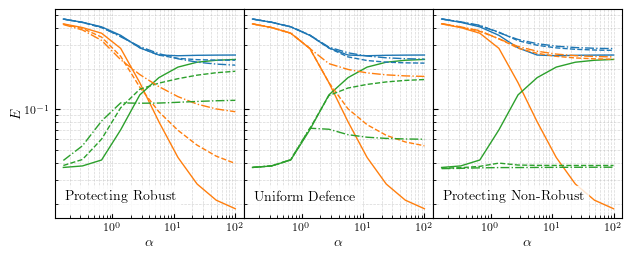

In [104]:

IMG_DIRECTORY = "./Assets/defence_sweep"
if not os.path.exists(IMG_DIRECTORY):
    os.makedirs(IMG_DIRECTORY)


def save_plot(fig, name, formats=["pdf","jpg"], date=False):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    for f in formats:        
        path = "{}".format(name) + "_{}".format(current_date) + "." + f
        if not date:
            path = "{}".format(name) + "." + f
        fig.savefig(            
            os.path.join(IMG_DIRECTORY, path),
            format=f,
        )


def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


# width = 2.5 * 458.63788
multiplier = 1.25
width = multiplier * 1.5 * 234.8775

plt.style.use("../latex_ready.mplstyle")

tuple_size = set_size(width, fraction=1.0, subplots=(1, 2))
tuple_size = (3*8.5/4,2.4)

multiplier = 1.25
second_multiplier = 0.6


# import Line2D for custom legend
from matplotlib.lines import Line2D

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=( tuple_size[0], tuple_size[1]),
    gridspec_kw={"hspace": 0,"wspace": 0},
)


# ICML adjustments
fig.subplots_adjust(left=0.08)
fig.subplots_adjust(bottom=0.12)
fig.subplots_adjust(top=0.99)
fig.subplots_adjust(right=0.97)

print("Figure size in inches: ", fig.get_size_inches())

axes = axes.flatten()

# Create a custom legend
custom_legend = []


for df_idx, (key, value) in enumerate(df_dict.items()):

    data_model_name = key

    axs = axes[df_idx]
    

    linestyles = ["solid", "dashed", "dashdot", "dotted"]

    for idx, (epsilon, eps_dict) in enumerate(value.items()):

        ax = axes[idx]

        alphas = eps_dict["alphas"]
        adversarial_error = eps_dict["adversarial_error"]
        generalization_error = eps_dict["generalization_error"]
        boundary_error = eps_dict["boundary_error"]
        class_preserving = eps_dict["class_preserving"]

        adversarial_error_erm = eps_dict["adversarial_error_erm"]
        generalization_error_erm = eps_dict["generalization_error_erm"]
        boundary_error_erm = eps_dict["boundary_error_erm"]
        class_preserving_erm = eps_dict["class_preserving_erm"]

        adversarial_error_erm_std = eps_dict["adversarial_error_erm_std"]
        generalization_error_erm_std = eps_dict["generalization_error_erm_std"]
        boundary_error_erm_std = eps_dict["boundary_error_erm_std"]
        class_preserving_erm_std = eps_dict["class_preserving_erm_std"]

        if df_idx == 0:

            custom_legend.append(Line2D([0],[0],color="C0", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{adv}}}}, \varepsilon_t={}$".format(epsilon)))
            custom_legend.append(Line2D([0],[0],color="C1", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{gen}}}}, \varepsilon_t={}$".format(epsilon)))
            custom_legend.append(Line2D([0],[0],color="C2", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{bound}}}}, \varepsilon_t={}$".format(epsilon)))
            custom_legend.append(Line2D([0],[0],color="C3", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{CP}}}}, \varepsilon_t={}$".format(epsilon)))
        

        adversarial_lines = axs.plot(alphas, adversarial_error, linestyle=linestyles[idx],color="C0")
        axs.plot(alphas, generalization_error, linestyle=linestyles[idx],color="C1")
        axs.plot(alphas, boundary_error,linestyle=linestyles[idx], color="C2")
        # axs.plot(alphas, class_preserving,linestyle=linestyles[idx], color="C3")

        axs.errorbar(
            alphas,
            adversarial_error_erm,
            yerr=adversarial_error_erm_std,
            fmt=".",
            markersize=1,
            color="C0"
        )
        axs.errorbar(
            alphas,
            generalization_error_erm,
            yerr=generalization_error_erm_std,
            fmt=".",
            markersize=1,
            color="C1"
        )
        axs.errorbar(
            alphas,
            boundary_error_erm,
            yerr=boundary_error_erm_std,
            fmt=".",
            markersize=1,
            color="C2"
        )
        axs.errorbar(
            alphas,
            class_preserving_erm,
            yerr=class_preserving_erm_std,
            fmt=".",
            markersize=1,
            color="C3"
        )


    axs.set_xscale("log")
    axs.set_yscale("log")


    if df_idx == 0:
        axs.set_ylabel(r"$E$", labelpad=2.0)
    # axs.set_ylabel(r"$E$", labelpad=2.0)


    axs.set_xlabel(r"$\alpha$", labelpad=2.0)
    axs.grid(which="both", axis="both", alpha=0.5)
    axs.legend(title=data_model_name, loc="lower left")
    # Set the major ticks to face inwards
    axs.tick_params(axis='both', which='major', direction='in')

    # Set the minor ticks to face inwards
    axs.tick_params(axis='both', which='minor', direction='in')


error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{CP}}$",color="C3"))

epsilon_legend = []

for idx, epsilon in enumerate(epsilons):
    epsilon_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\varepsilon_t={}$".format(epsilons[idx]))) 

custom_legend = []

for idx in range(3):
    custom_legend.append(error_legend[idx])
    custom_legend.append(epsilon_legend[idx])

custom_legend.append(error_legend[-1])

# Place the legend at the bottom of the figure
# fig.legend(handles=custom_legend, loc='upper center', ncol=4)

save = True
if save:
    save_plot(
        fig,
        f"defence_sweep",
    )

plt.show()





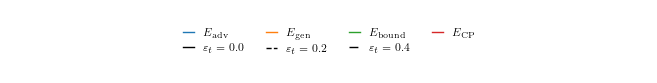

In [102]:
# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( tuple_size[0], 0.1 * tuple_size[0]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

figlegend.legend(
    handles=custom_legend,
    handlelength=1,
    loc="center",
    ncol=4,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "legend.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()



Figure size in inches:  [0.6375 1.2   ]


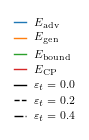

In [103]:
# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( 0.1*tuple_size[0], 0.5*tuple_size[1]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

# display figure size
print("Figure size in inches: ", figlegend.get_size_inches())

error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{CP}}$",color="C3"))

epsilon_legend = []

for idx, epsilon in enumerate(epsilons):
    epsilon_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\varepsilon_t={}$".format(epsilons[idx]))) 


# merge the two legends by concatenating the lists
custom_legend = error_legend + epsilon_legend


figlegend.legend(
    handles=custom_legend,
    handlelength=1,
    loc="center",
    ncol=1,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "vertical_legend.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()

